In [1]:
from threading import Thread
from multiprocessing import Process
import os
import time
import datetime
import socket
import itertools
import json

%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
from IPython.display import clear_output

import logging
logging.basicConfig(level=logging.INFO)

In [4]:
'''necessary globals due to pecularities of matplotlib for live plotting, subject to change'''
n_channels = 8
# Empty dataframe with columns ["time","ch1",..,"ch8", "sampling_rate"]
df = pd.DataFrame({"time" if i == 0 else\
                   f"{i}" if i <= n_channels else\
                   "sampling_rate":pd.Series([],dtype="float64")
                   for i in range(0,n_channels+2) })

recording = False

data = df
class EEGStream:
    
    def __init__(self):
        global df
        self.data = df
        self.buffer = df
        
        '''Feel free to change the time_window,fps and pkg_limit. Other changes probably break the programm'''
        self.time_window = 2                     # time window for each frame of the plot in seconds
        self.sampling_rate = 222                   # expected sampling_rate
        self.xwindow= int(self.sampling_rate*self.time_window) # Expected number of simultaneously plotted data
        self.fps = 25                              # refresh rate for the live plot
        self.pkg_limit = 5000 # stop streaming after this is reached

    def live_plot(self):
        '''
        Starts a thread that records data from the socket and shows a live plot
        '''
        global recording
        recording = False   
        recording_thread = Thread(target=self.record,daemon=True) 
        recording_thread.start()  #Turns recording True after a moment
        
        logging.info("Waiting for incoming data..")
        while not recording:
            time.sleep(0.5)
            
        self.build_plot()
        self.animate_plot()

        if input("Stream Again? | 'y' for 'yes'") == 'y':
            self.live_plot()
            clear_output()
        else:
            return
        
        recording_thread.join() # Wait for the thread to end properly
        
                                #=== PLOT RELATED FUNCTIONS ===#
    
    def build_plot(self):
        # Preparing the Plot and extracting the lines
        self.data.plot(x="time", y= [str(channel+1) for channel in range(n_channels)])
        self.fig = plt.gcf()
        self.lines = [line for line in self.fig.gca().lines]

        # Setting Some Plot properties
        self.fig.gca().set_title("EEG Streaming @ 0 Hz")
        self.fig.gca().set_ylim(-2500,2500)
        self.fig.gca().set_xlabel("time [s]")
        self.fig.gca().set_ylabel("signal [mV]")

        
    def animate_plot(self):
        global recording
        
        interval = 1/self.fps
        while recording:
            time.sleep(interval)
            success = self.update_lines()
            self.fig.canvas.draw()
        
        return 
    
    def update_lines(self):
        global data

        # Update Lines
        for i,line in enumerate(self.lines):
            line.set_data(data.time, data[f"{i+1}"])
        
        #Update x-axis and other plot elements
        right = data.time.iloc[-1]
        left = right-self.time_window
        self.fig.gca().set_xlim(left,right)

        self.fig.gca().set_title(f"Traumschreiber Streaming @ {data.sampling_rate.iloc[-1]}Hz")
        self.fig.gca().legend(loc="upper right")
        
        return 

    
                          #=== SOCKET STREAMING RELATED FUNCTIONS ===#
        
                    
    def build_connection(self,host="",port=65432):
        '''
        Creates a UDP Socket and waits for a connection with the specified parameters.
        
        returns
        ss : streaming socket
        connection 
        '''
        ss = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

        try:
            # reuse address:port if on use
            # otherwise process needs to be killed if socket wasn't closed
            ss.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
            ss.bind((host, port))  # associate the socket with an address and port
        except socket.error as e:
            print(str(e))

        print("Waiting for a Connection..")

        ss.listen()  # listening socket, ready to accept connections

        connection, address = ss.accept()  # wait for incoming connections
        ip = address[0]  # socket sender IP
        port = address[1]  # socket sender port
        print(f"Connected to {ip}:{port}")
        self.socket = ss
        return ss, connection

    def record(self, buffersize=1):
        '''
        Builds a connection, reads data from it and creates packages in the form of dictionaries.
        Expects incoming data to be stringified json files. 
        '''
        global recording
        socket, connection = self.build_connection()

        pkg = ""        # 1 pkg: 1 json object
        pkg_count = 0
        empty_msgs = 0  # counter

        start_time = time.time()
        sampling_rate = 0 
        
        # loop for handling incoming data
        while True:  
            # Receive data (buffer length=1byte)
            response = connection.recv(buffersize).decode("utf-8")   

            # Count Empty Responses
            if not response: 
                empty_msgs += 1  
                if empty_msgs > 1000: break

            # Beginning of Package
            if "{" in response:  
                pkg += response[response.index("{"):]  # add everything after first curly
                empty_msgs = 0   # reset counter

            # Content
            elif "}" not in response: 
                pkg += response

            # End of Package 
            else:
                
                pkg_count += 1
                pkg += response
               
                elapsed = (time.time() - start_time)
                json_string = pkg.rstrip("\n").strip() # remove ending break lines and white spaces
                current = json.loads(json_string)  # parse stringified JSON as dict
                
                sampling_rate = int(pkg_count / elapsed) if pkg_count > 1 else 0
                
                self.store(elapsed,current,sampling_rate)  # add current read package for plotting 
                empty_msgs = 0
                pkg = pkg[pkg.index("}")+1:]  # only keep data after the end of the first package
                
                if pkg_count > self.xwindow+20:
                    recording=True
                if pkg_count > self.pkg_limit: break

        socket.close()  # disconnect listening socket
        logging.info("Ended Streaming Session")
        recording = False
        # Save Data
        if input("Save Recorded data?  | 'y' for 'yes'") == 'y':
            self.to_csv() 
            
        return
        
                                        #=== STORAGE RELATED FUNCTIONS ===#
    def store(self, elapsed, current, sampling_rate):
        global data
        '''
        Rearranges incoming data into a dictionary of the following form
        
            'time':elapsed,
            '1':mV1, 
            |...
            '8':mV8,
            'sampling_rate':sampling_rate
            
        '''
        
        xwindow = self.xwindow
        
        del current["time"]
        datadic = {**{'time':elapsed}, **current, **{'sampling_rate':sampling_rate}}
        self.data = self.data.append(datadic, ignore_index=True)
        if self.data.shape[0] > xwindow+20:
            #self.data[-xwindow:].to_csv("sessions/temp/plot_data.csv")
            data = self.data[-xwindow:]
              
    def to_csv(self):
        if 'sessions' not in os.listdir():
            os.mkdir('sessions')
        time = datetime.datetime.now().strftime("%Y-%m-%d-%H%M")
        filepath = f"sessions/{time}.csv"
        self.data.to_csv(filepath)
        print(f"Data saved to {filepath}")
        return
    
eeg = EEGStream()

Resize the plot above according to your preferences by dragging at its edges before you run the next cell .

INFO:root:Waiting for incoming data..


Waiting for a Connection..
Connected to 192.168.0.105:38530


<IPython.core.display.Javascript object>


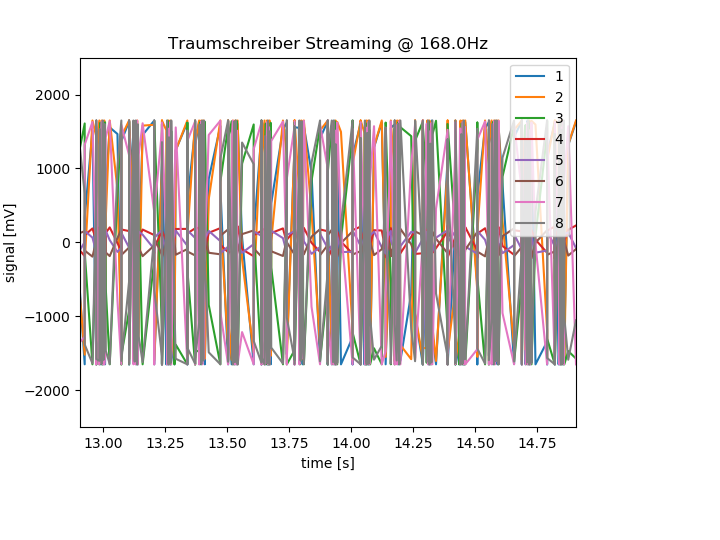

INFO:root:Ended Streaming Session


In [ ]:
eeg.live_plot()